**Install Packages**

In [1]:
%pip install rasterio keras

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


**Import Libraries**

In [2]:
## Import Libraries
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import load_model
from rasterio.plot import show
import folium


**Defining Paths**

In [42]:
project_path = './'
os.chdir(project_path)

data_dir = 'data/landsat/'
processed_dir = 'data/processed/kmeans'
results_dir = 'data/results/normal/kmeans'
visualizations_dir = 'visualization/normal/kmeans'

os.makedirs(processed_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

red_band_path = os.path.join(data_dir, 'LC08_L1TP_020032_20240727_20240801_02_T1_B4.TIF')
nir_band_path = os.path.join(data_dir, 'LC08_L1TP_020032_20240727_20240801_02_T1_B5.TIF')
thermal_band_path = os.path.join(data_dir, 'LC08_L1TP_020032_20240727_20240801_02_T1_B10.TIF')
ndvi_output_path = os.path.join(processed_dir, 'ndvi.tif')
lst_output_path = os.path.join(processed_dir, 'lst.tif')
uhi_output_path = os.path.join(results_dir, 'uhi_detection.tif')

ndvi_path = f"{project_path}/{ndvi_output_path}"
lst_path = f"{project_path}/{lst_output_path}"
kmeans_output_path = os.path.join(results_dir, 'uhi_detection_kmeans.tif')

lst_visual_path = os.path.join(visualizations_dir, 'lst.png')
uhi_visual_path = os.path.join(visualizations_dir, 'uhi_detection_kmeans.png')
ndvi_visual_path = os.path.join(visualizations_dir, 'ndvi.png')
kmeans_visual_path = os.path.join(visualizations_dir, 'kmeans.png')
threshold_visual_path = os.path.join(visualizations_dir, 'threshold.png')



**Calculate NVDI**

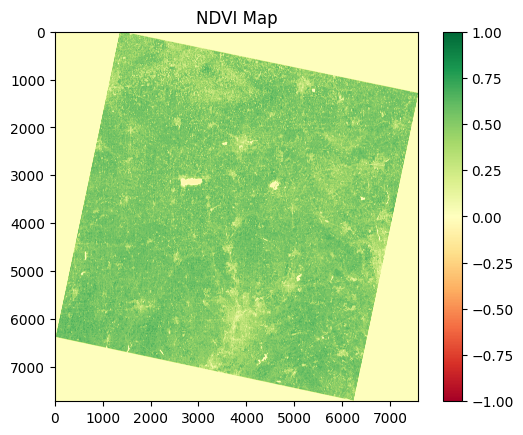

In [36]:
def calculate_ndvi(red_band_path, nir_band_path, output_path):
    with rasterio.open(red_band_path) as red_src:
        red = red_src.read(1).astype(float)  # Ensure float for division
        profile = red_src.profile  # Get the metadata

    with rasterio.open(nir_band_path) as nir_src:
        nir = nir_src.read(1).astype(float)  # Ensure float for division

    epsilon = 1e-10  # Small number to avoid division by zero
    ndvi = (nir - red) / (nir + red + epsilon)

    # Only clip values that are finite
    ndvi = np.where(np.isfinite(ndvi), np.clip(ndvi, -1, 1), np.nan)

    # Update the raster profile for single-band float32 output
    profile.update(dtype=rasterio.float32, count=1)

    # Save the NDVI image as a GeoTIFF
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(ndvi.astype(rasterio.float32), 1)

    return ndvi


# Calculate NDVI
ndvi = calculate_ndvi(red_band_path, nir_band_path, ndvi_output_path)

# Display the NDVI
plt.imshow(ndvi, cmap='RdYlGn')
plt.title('NDVI Map')
plt.colorbar()
plt.savefig(ndvi_visual_path, bbox_inches='tight', dpi=300)
plt.show()

**Plot NDVI TIFF**

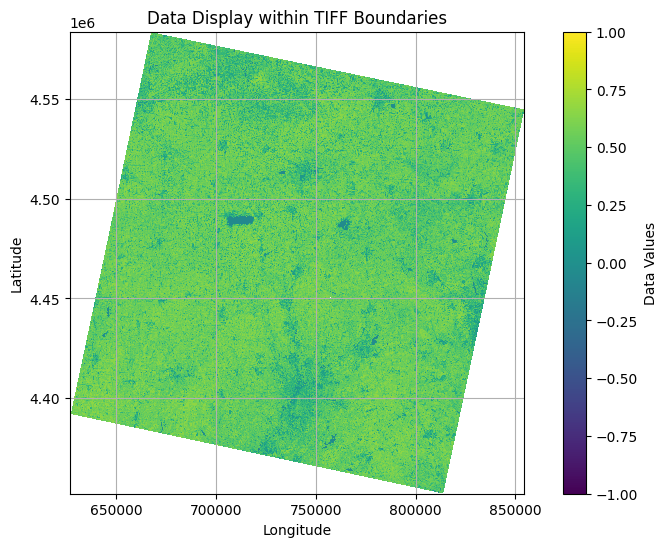

In [5]:
tiff_path=nir_band_path

def plot_tiff_within_boundaries(tiff_path):
    with rasterio.open(tiff_path) as src:
        data = src.read(1)  # Read the first band
        # Mask out values that are no-data in the dataset
        data[data == src.nodata] = np.nan  # Assuming the nodata value is set in the TIFF
        # Get the geographic bounds
        bounds = src.bounds
        min_x, min_y, max_x, max_y = bounds.left, bounds.bottom, bounds.right, bounds.top

    # Create a custom colormap that sets 'bad' (NaN) values to a specific color, e.g., transparent or white
    cmap = plt.cm.viridis
    cmap.set_bad(color='white')  # Setting NaN values to white for visibility

    plt.figure(figsize=(10, 6))
    plt.imshow(data, cmap=cmap, interpolation='none', extent=[min_x, max_x, min_y, max_y])
    plt.colorbar(label='Data Values')
    plt.title('Data Display within TIFF Boundaries')
    plt.xlim([min_x, max_x])
    plt.ylim([min_y, max_y])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()

# Path to your TIFF file
tiff_path = ndvi_output_path
plot_tiff_within_boundaries(tiff_path)

**Calculate LST**

In [37]:
# def calculate_lst(thermal_band_path, output_path):
#     with rasterio.open(thermal_band_path) as thermal_src:
#         thermal = thermal_src.read(1).astype(float)
#         profile = thermal_src.profile

#     # Convert DN to radiance and then to temperature
#     ML = 3.342e-4
#     AL = 0.1

#     radiance = thermal * ML + AL
#     lst = (radiance - 273.15)
#     lst[~np.isfinite(lst)] = np.nan

#     profile.update(dtype=rasterio.float32, count=1)
#     with rasterio.open(output_path, 'w', **profile) as dst:
#         dst.write(lst.astype(rasterio.float32), 1)

#     return lst

# # Define file paths
# thermal_band_path = thermal_band_path
# lst_output_path = os.path.join(processed_dir, 'lst.tif')
# # Calculate LST
# lst = calculate_lst(thermal_band_path, lst_output_path)

# # Create a custom colormap that sets 'bad' (NaN) values to a specific color, e.g., transparent or white
# cmap = plt.cm.hot
# cmap.set_bad(color='white')  # Setting NaN values to white for visibility

# # Display the LST
# plt.imshow(lst, cmap=cmap, interpolation='none')
# plt.title('Land Surface Temperature (LST)')
# plt.colorbar()
# plt.show()

def calculate_lst(thermal_band_path, output_path):
    with rasterio.open(thermal_band_path) as thermal_src:
        thermal = thermal_src.read(1).astype(float)
        profile = thermal_src.profile

        # Handle no-data values
        nodata = thermal_src.nodata
        if nodata is not None:
            thermal[thermal == nodata] = np.nan
        else:
            thermal[thermal <= 0] = np.nan  # Adjust based on data characteristics

    # Constants for Landsat 8 Band 10 (Adjust if using different data)
    ML = 0.0003342
    AL = 0.1
    K1 = 774.8853
    K2 = 1321.0789

    # Convert DN to radiance
    radiance = ML * thermal + AL

    # Convert radiance to brightness temperature
    brightness_temp = K2 / np.log((K1 / radiance) + 1) - 273.15

    # Replace invalid values with NaN
    brightness_temp[~np.isfinite(brightness_temp)] = np.nan

    # Set unrealistic temperature values to NaN
    brightness_temp[brightness_temp < -100] = np.nan  # Adjust threshold as needed

    # Update profile
    profile.update(dtype=rasterio.float32, count=1, nodata=np.nan)

    # Save to GeoTIFF
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(brightness_temp.astype(rasterio.float32), 1)

    return brightness_temp

**Visualize LST**

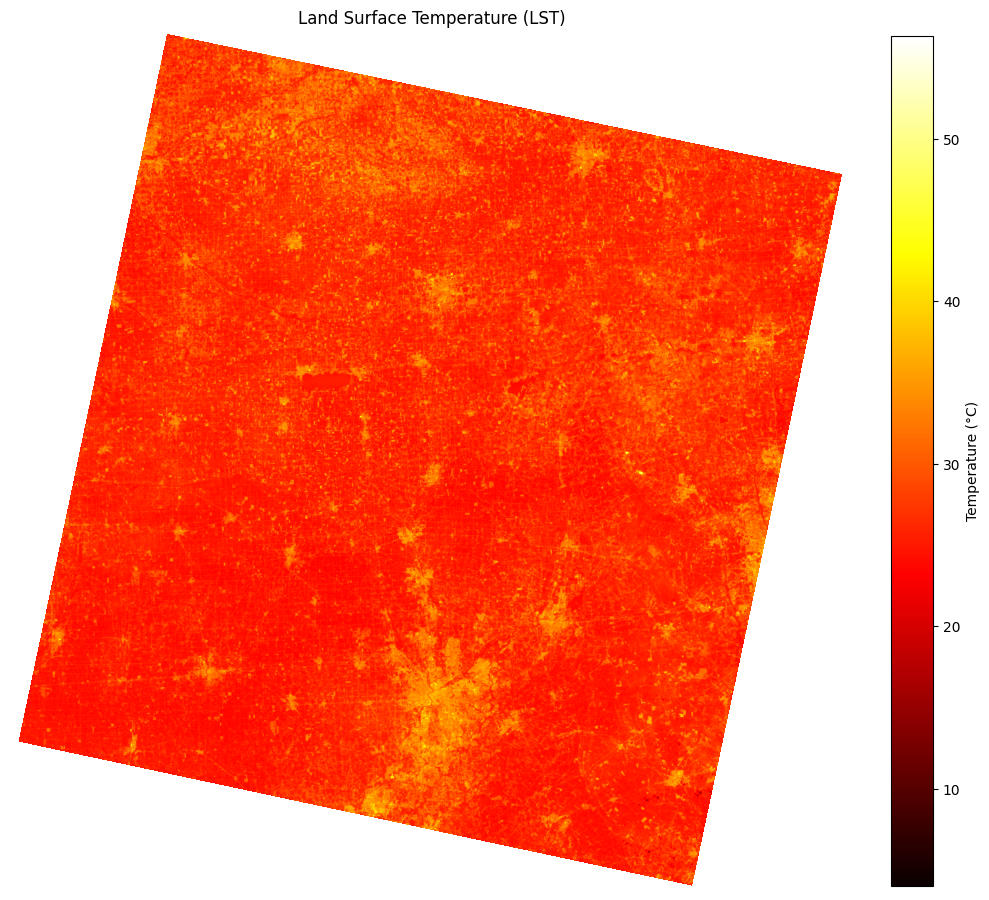

In [ ]:
def visualize_lst(lst, output_path):
    """
    Visualize Land Surface Temperature (LST)
    """
    plt.figure(figsize=(10, 10))  # Square figure to maintain aspect ratio
    cmap = plt.cm.hot
    cmap.set_bad(color='white')  # For NaN values

    im = plt.imshow(lst, cmap=cmap)
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.set_label('Temperature (°C)')
    
    plt.title('Land Surface Temperature (LST)')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(lst_visual_path, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

# Calculate LST
lst = calculate_lst(thermal_band_path, lst_output_path)

# Visualize LST
visualize_lst(lst, lst_visual_path)

**KMeans UHI Detection**

Preparing features...
Applying K-Means clustering...


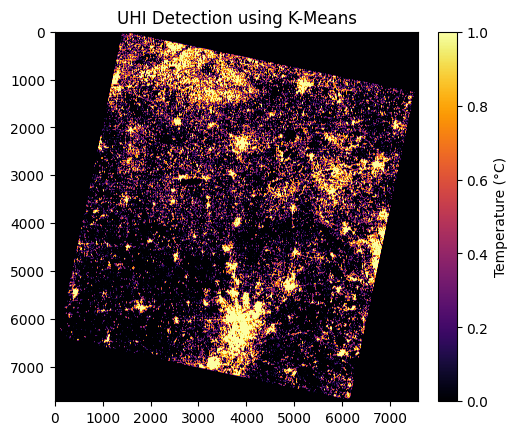

Performing UHI detection...
Preparing features...
Applying K-Means clustering...


In [46]:
def kmeans_uhi_detection(lst, ndvi, n_clusters=2):
    """
    Implements UHI detection using K-Means clustering algorithm
    """
    def prepare_features(lst, ndvi):
        # Flatten arrays
        lst_flat = lst.flatten()
        ndvi_flat = ndvi.flatten()

        # Create valid mask
        valid_mask = (
            np.isfinite(lst_flat) & 
            np.isfinite(ndvi_flat) & 
            (lst_flat != 0)
        )

        # Extract valid data points
        X = np.column_stack((
            lst_flat[valid_mask],
            ndvi_flat[valid_mask]
        ))

        return X, valid_mask

    # Prepare data
    print("Preparing features...")
    X, valid_mask = prepare_features(lst, ndvi)

    # Apply K-Means clustering
    print("Applying K-Means clustering...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    
    # Get cluster labels
    cluster_labels = kmeans.labels_

    # Create output mask
    uhi_mask = np.full(lst.shape, -1, dtype=np.int32)
    uhi_mask.flat[valid_mask] = cluster_labels

    # Determine which cluster represents UHI based on LST mean
    cluster_means = [np.mean(X[cluster_labels == i, 0]) for i in range(n_clusters)]
    uhi_cluster = np.argmax(cluster_means)  # Cluster with the highest mean LST is UHI

    # Update UHI mask to binary (1 for UHI, 0 for non-UHI)
    uhi_mask = (uhi_mask == uhi_cluster).astype(int)

    results = {
        'uhi_mask': uhi_mask,
        'model': kmeans,
        'cluster_means': cluster_means
    }

    return results

results = kmeans_uhi_detection(lst, ndvi)
uhi_mask = results['uhi_mask']

# Visualize the UHI mask
im = plt.imshow(uhi_mask, cmap='inferno')
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label('Temperature (°C)')
plt.title('UHI Detection using K-Means')
plt.savefig(kmeans_visual_path, bbox_inches='tight', dpi=300)
plt.show()
# Perform UHI detection
print("Performing UHI detection...")
results = kmeans_uhi_detection(lst, ndvi)

# # Save UHI mask
# uhi_output_path = os.path.join(results_dir, 'uhi_detection_kmeans.tif')
# with rasterio.open(thermal_band_path) as src:
#     profile = src.profile
#     profile.update(dtype=rasterio.int32, count=1)
    
#     with rasterio.open(uhi_output_path, 'w', **profile) as dst:
#         dst.write(results['uhi_mask'].astype(rasterio.int32), 1)

**Visualize UHI**

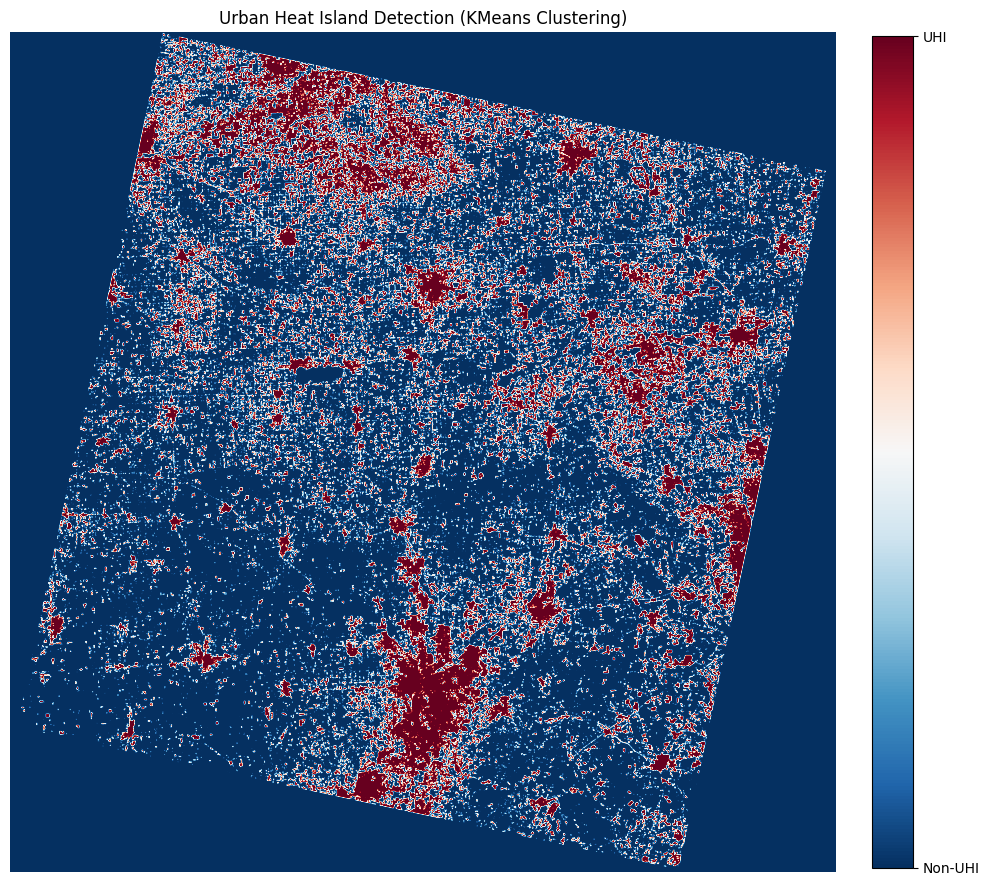

In [18]:
def visualize_results(uhi_mask, output_path, title='UHI Detection'):
    """
    Visualize UHI detection results
    """
    plt.figure(figsize=(10, 10))  # Square figure to maintain aspect ratio
    
    # Create custom colormap
    cmap = plt.cm.RdBu_r
    cmap.set_bad(color='white')  # Set color for masked areas
    
    # Plot the UHI mask
    masked_data = np.ma.masked_where(uhi_mask == -1, uhi_mask)
    im = plt.imshow(masked_data, cmap=cmap)
    
    # Add colorbar
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(['Non-UHI', 'UHI'])
    
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(output_path, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()


visualize_results(results['uhi_mask'], uhi_visual_path, title='Urban Heat Island Detection (KMeans Clustering)')

Preparing features...
Applying K-Means clustering...

Results:
Cluster Means: [25.793757621201507, 30.916654317340775]


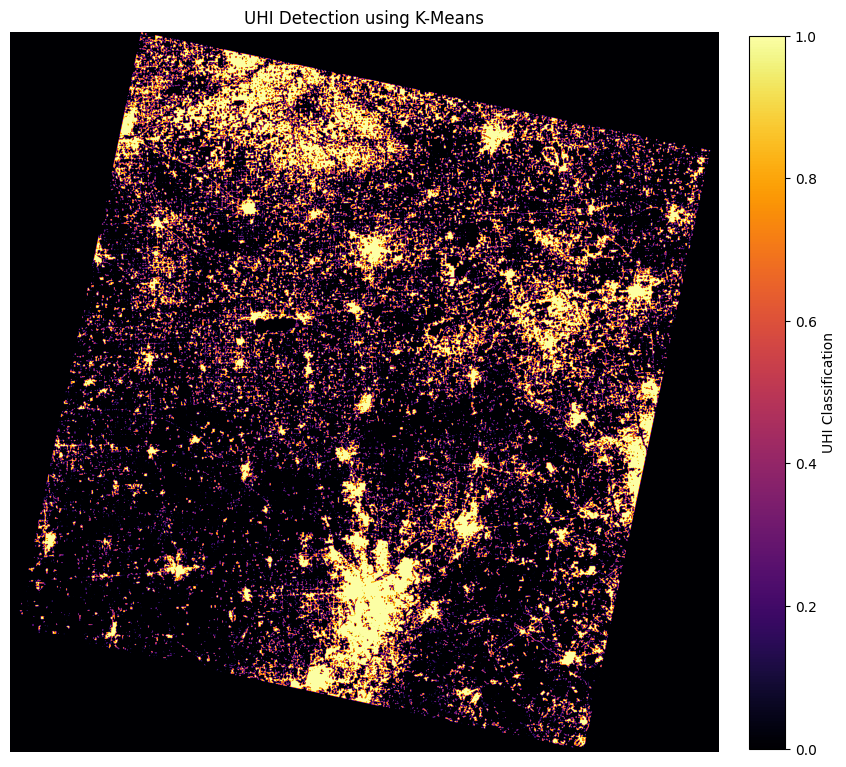

In [47]:
# Perform UHI detection using K-Means clustering
results = kmeans_uhi_detection(lst, ndvi)

# Extract the UHI mask and cluster means from the results
uhi_mask = results['uhi_mask']
cluster_means = results['cluster_means']

# Print results
print("\nResults:")
print(f"Cluster Means: {cluster_means}")

# Visualize the UHI mask
plt.figure(figsize=(10, 10))
im = plt.imshow(uhi_mask, cmap='inferno')
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label('UHI Classification')
plt.title('UHI Detection using K-Means')
plt.savefig(kmeans_visual_path, bbox_inches='tight', dpi=300)
plt.axis('off')
plt.show()

**Read Raster Data**

.//data/processed/kmeans\ndvi.tif
.//data/processed/kmeans\lst.tif


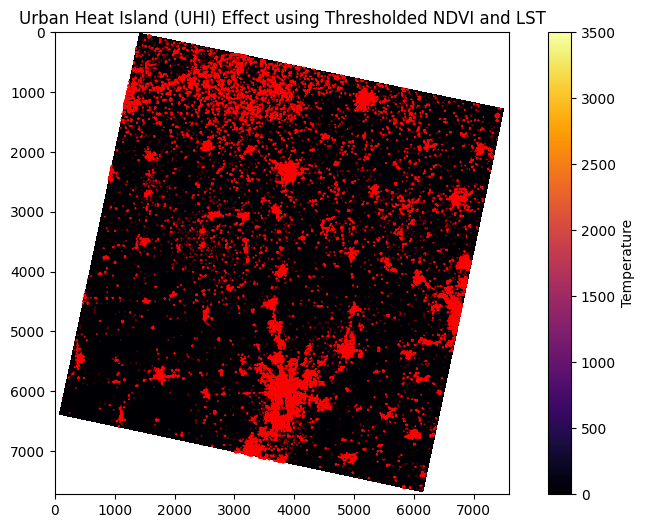

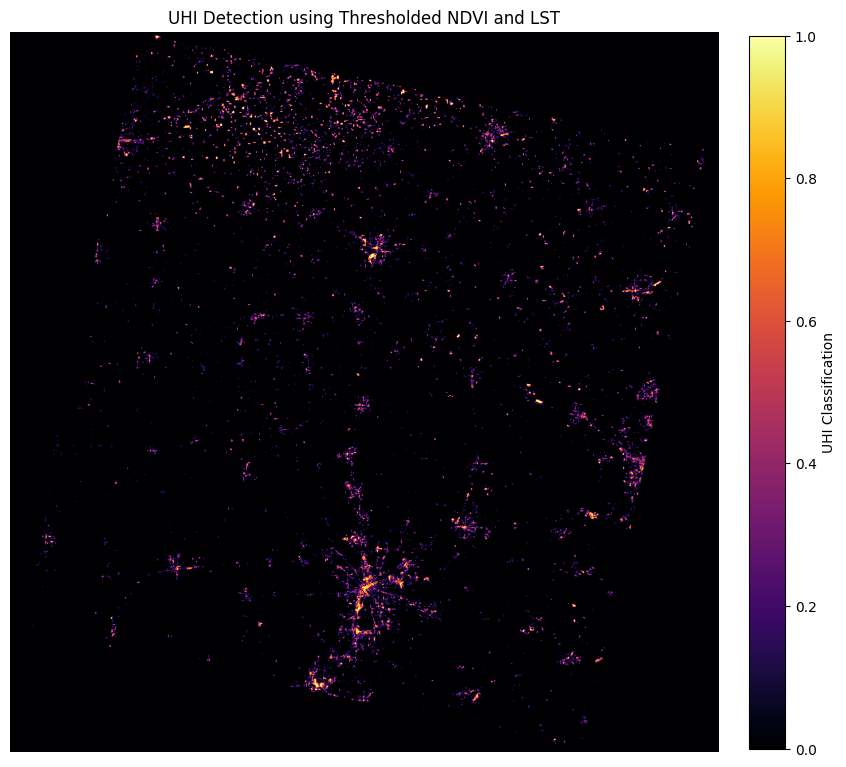

In [51]:
def read_raster(file_path):
    with rasterio.open(file_path) as src:
        data = src.read(1).astype(float)  # Read the first band and convert to float
        nodata = src.nodata  # Get the no-data value
        data[data == nodata] = np.nan  # Replace no-data values with NaN
    return data

# Paths to your NDVI and LST images
ndvi_path = f"{project_path}/{ndvi_output_path}"
lst_path = f"{project_path}/{lst_output_path}"
print(ndvi_path)
print(lst_path)

# Read the rasters
ndvi = read_raster(ndvi_path)
lst = read_raster(lst_path)

# You can adjust this threshold according to your analysis needs
ndvi_threshold = 0.2  # Common threshold to identify vegetated areas
hotspots = (ndvi < ndvi_threshold) & (lst > np.percentile(lst[~np.isnan(lst)], 90))

# Plotting the UHI effect based on LST where NDVI is low
plt.figure(figsize=(10, 6))
plt.title('Urban Heat Island (UHI) Effect using Thresholded NDVI and LST')
# Create a colormap that sets 'bad' (NaN) values to a specific color, e.g., transparent or white
cmap = plt.get_cmap('inferno')
cmap.set_bad(color='white')

# Display the LST with NaN values shown in white
plt.imshow(lst, cmap=cmap, vmin=0, vmax=3500, interpolation='none')
plt.colorbar(label='Temperature')

# Overlay contours for hotspots
plt.contour(hotspots, colors='red', linewidths=1)
plt.grid(False)
# plt.show()

plt.figure(figsize=(10, 10))
im = plt.imshow(hotspots, cmap='inferno')
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label('UHI Classification')
plt.title('UHI Detection using Thresholded NDVI and LST')
plt.savefig(threshold_visual_path, bbox_inches='tight', dpi=300)
plt.axis('off')
plt.show()